In [1]:
# Install required packages
!pip install fastapi uvicorn python-multipart pillow ultralytics torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
from PIL import Image
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00
Mounted at /content/drive


Data Preprocessing & Custom Dataset Class

In [2]:
# Define class names
class_names = ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']

class GarbageDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get label from corresponding txt file
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))

        # For classification, we use the first object's class as the image label
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    # Get the first object's class
                    class_id = int(lines[0].split()[0])
                else:
                    class_id = 0  # Default to first class if no labels
        except:
            class_id = 0

        if self.transform:
            image = self.transform(image)

        return image, class_id

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GarbageDataset(
    '/content/drive/MyDrive/GARBAGE_CLASSIFICATION/train/images',
    '/content/drive/MyDrive/GARBAGE_CLASSIFICATION/train/labels',
    train_transform
)

val_dataset = GarbageDataset(
    '/content/drive/MyDrive/GARBAGE_CLASSIFICATION/valid/images',
    '/content/drive/MyDrive/GARBAGE_CLASSIFICATION/valid/labels',
    val_transform
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Custom CNN Model for Fast Training

In [3]:
class FastGarbageCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(FastGarbageCNN, self).__init__()

        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FastGarbageCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Training Loop with Metrics Tracking

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Train the model
print("Starting training...")
train_losses, val_losses, train_accs, val_accs, val_preds, val_labels = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15
)

Starting training...
Epoch [1/15]
Train Loss: 1.4926, Train Acc: 46.52%
Val Loss: 1.1019, Val Acc: 56.43%
--------------------------------------------------
Epoch [2/15]
Train Loss: 1.2317, Train Acc: 53.40%
Val Loss: 0.9666, Val Acc: 68.49%
--------------------------------------------------
Epoch [3/15]
Train Loss: 1.1793, Train Acc: 56.21%
Val Loss: 0.9973, Val Acc: 64.68%
--------------------------------------------------
Epoch [4/15]
Train Loss: 1.1520, Train Acc: 57.76%
Val Loss: 0.8715, Val Acc: 72.26%
--------------------------------------------------
Epoch [5/15]
Train Loss: 1.0958, Train Acc: 59.69%
Val Loss: 1.0010, Val Acc: 64.68%
--------------------------------------------------
Epoch [6/15]
Train Loss: 1.0623, Train Acc: 61.77%
Val Loss: 0.8174, Val Acc: 73.69%
--------------------------------------------------
Epoch [7/15]
Train Loss: 1.0352, Train Acc: 62.74%
Val Loss: 0.8242, Val Acc: 71.97%
--------------------------------------------------
Epoch [8/15]
Train Loss: 1.

Plotting Results

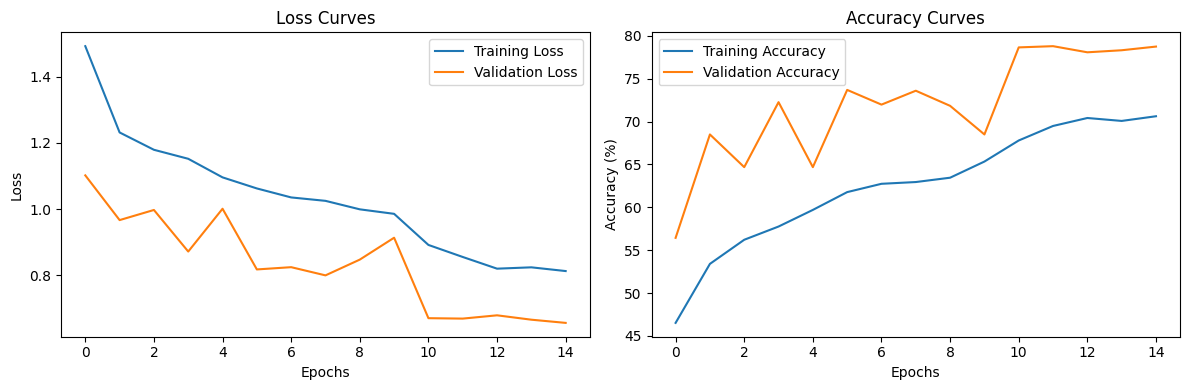

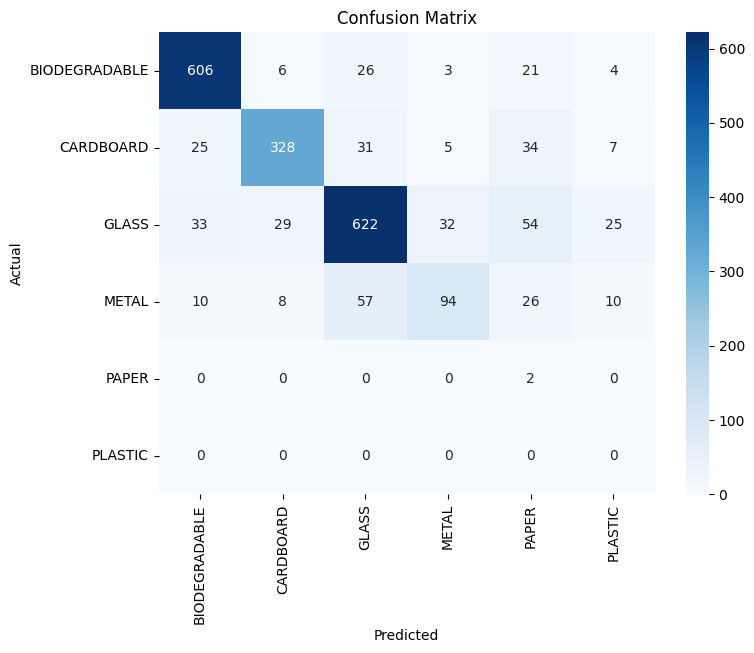

Classification Report:
               precision    recall  f1-score   support

BIODEGRADABLE       0.90      0.91      0.90       666
    CARDBOARD       0.88      0.76      0.82       430
        GLASS       0.85      0.78      0.81       795
        METAL       0.70      0.46      0.55       205
        PAPER       0.01      1.00      0.03         2
      PLASTIC       0.00      0.00      0.00         0

     accuracy                           0.79      2098
    macro avg       0.56      0.65      0.52      2098
 weighted avg       0.86      0.79      0.82      2098



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names))

Save the Model

In [1]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/GARBAGE_CLASSIFICATION/garbage_cnn_model.h5')

# Save class names
import json
with open('/content/drive/MyDrive/GARBAGE_CLASSIFICATION/class_names.json', 'w') as f:
    json.dump(class_names, f)

print("Model and class names saved successfully!")

NameError: name 'torch' is not defined